In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd '/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code'

/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code


In [2]:
!pip install scanpy
!pip install stlearn 
!pip install matplotlib==3.4.3
!pip install preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
import sys 

import os
from copy import deepcopy
import numpy as np
import pandas as pd
import stlearn as st

import torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join('../../FPST','code'))
if module_path not in sys.path:
    sys.path.append(module_path)

from load_data import Data, load_visium_data
from train import engine
from image_data import *
from models import NMF
from plot import plot_train_vs_test, plot_genes_read_count, plot_true_vs_reconstructed_histogram
from losses import RMSELossWithoutZeros

# choose the device 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


## Dataset Name

In [7]:
dataset_name = '../data/Visium_Mouse_Olfactory_Bulb'


## Load data using stlearn

In [5]:
# data = st.Read10X(dataset_name)
# st.pp.filter_genes(data, min_cells=177)
# st.pp.filter_genes(data, min_counts=10)
# X = data.X.toarray()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## NMF- random spots

In [ ]:
dataset, data = load_visium_data(dataset_name, min_cells=177, min_counts=10)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

In [ ]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(data.n_vars, data.n_obs, params)

In [ ]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [ ]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 71449/71449 [04:56<00:00, 241.17it/s]


Epoch #0 Train Loss: 1.152004762276567
Epoch #0 Test Loss: 1.1467583230868297


Train epoch 1/300: 100%|██████████| 71449/71449 [05:03<00:00, 235.07it/s]


Epoch #1 Train Loss: 1.0685443391509701
Epoch #1 Test Loss: 0.9158105930391706


Train epoch 2/300: 100%|██████████| 71449/71449 [05:15<00:00, 226.19it/s]


Epoch #2 Train Loss: 0.9349542463721048
Epoch #2 Test Loss: 0.8191870883190417


Train epoch 3/300: 100%|██████████| 71449/71449 [05:18<00:00, 224.17it/s]


Epoch #3 Train Loss: 0.8595503701889774
Epoch #3 Test Loss: 0.7658401610118761


Train epoch 4/300: 100%|██████████| 71449/71449 [05:23<00:00, 221.18it/s]


Epoch #4 Train Loss: 0.8103149930182715
Epoch #4 Test Loss: 0.7310484155777068


Train epoch 5/300: 100%|██████████| 71449/71449 [05:33<00:00, 214.09it/s]


Epoch #5 Train Loss: 0.774804492689282
Epoch #5 Test Loss: 0.7059266533240882


Train epoch 6/300: 100%|██████████| 71449/71449 [05:36<00:00, 212.52it/s]


Epoch #6 Train Loss: 0.7477666475592044
Epoch #6 Test Loss: 0.6869815957015563


Train epoch 7/300: 100%|██████████| 71449/71449 [05:44<00:00, 207.48it/s]


Epoch #7 Train Loss: 0.7264966124793208
Epoch #7 Test Loss: 0.6721623128772359


Train epoch 8/300: 100%|██████████| 71449/71449 [05:42<00:00, 208.82it/s]


Epoch #8 Train Loss: 0.709285950648102
Epoch #8 Test Loss: 0.6602435668730772


Train epoch 9/300: 100%|██████████| 71449/71449 [05:47<00:00, 205.87it/s]


Epoch #9 Train Loss: 0.6950629965419391
Epoch #9 Test Loss: 0.6504598597895096


Train epoch 10/300: 100%|██████████| 71449/71449 [05:56<00:00, 200.56it/s]


Epoch #10 Train Loss: 0.6831025289589343
Epoch #10 Test Loss: 0.6422794591869408
Early stopping


### Plot train and test vs epochs

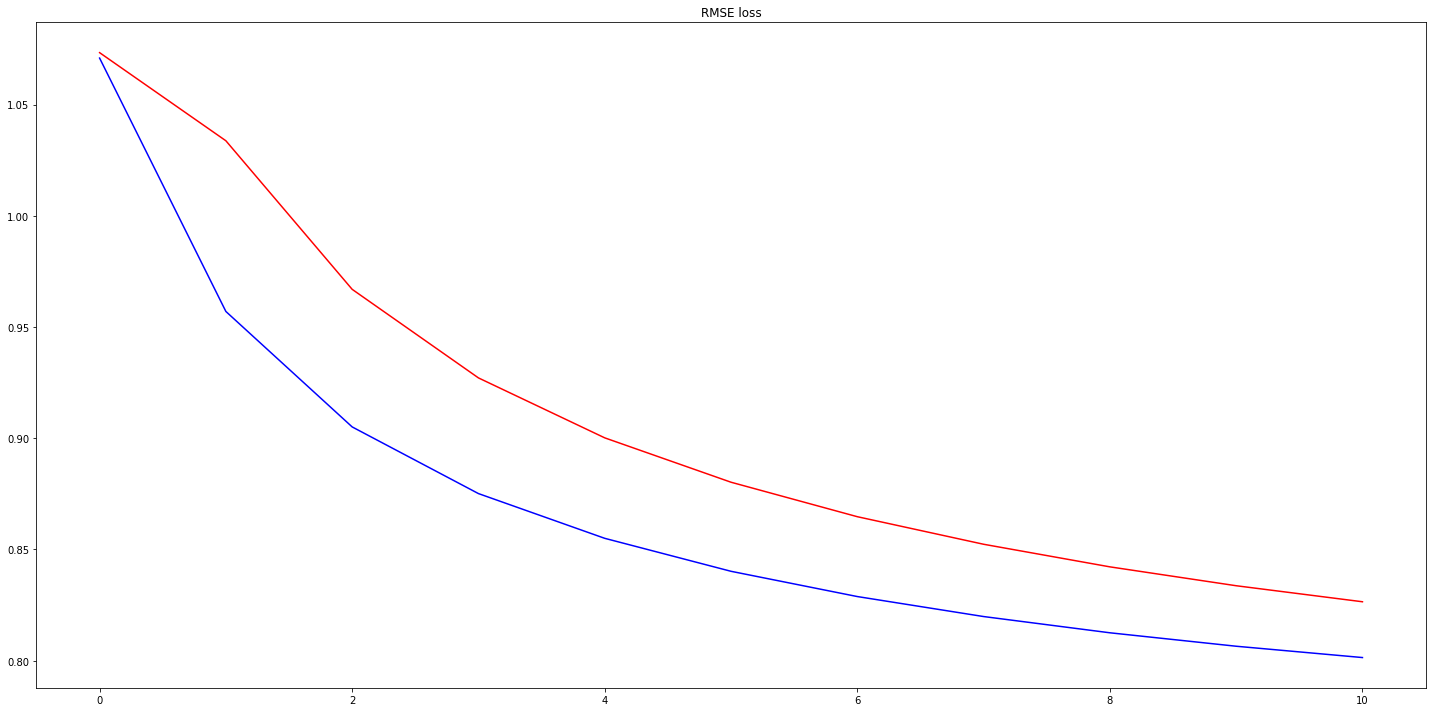

In [ ]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[0.37787884 0.37637007 0.35321856 ... 0.73881072 1.43992317 0.37142086]
 [0.87238103 0.77928019 0.7

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


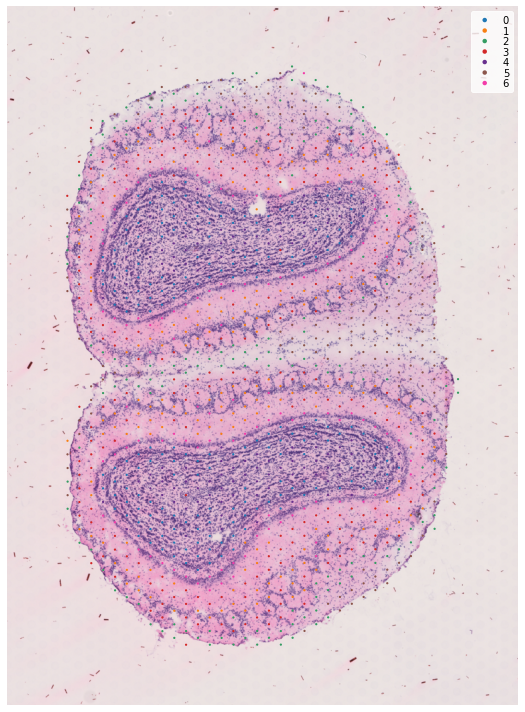

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

## NMF- data per spot

In [ ]:
dataset, data = load_visium_data(dataset_name, 'spots_data', min_cells=177, min_counts=10)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

In [ ]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(number_of_genes, number_of_spots, params)

In [ ]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [ ]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 90421/90421 [06:34<00:00, 229.08it/s]


Epoch #0 Train Loss: 1.016254504821904
Epoch #0 Test Loss: 1.106961207580438


Train epoch 1/300: 100%|██████████| 90421/90421 [07:08<00:00, 211.01it/s]


Epoch #1 Train Loss: 0.856635200503463
Epoch #1 Test Loss: 1.1064111090071675


Train epoch 2/300: 100%|██████████| 90421/90421 [07:31<00:00, 200.12it/s]


Epoch #2 Train Loss: 0.7723656077707914
Epoch #2 Test Loss: 1.1060826411198688
Early stopping


### Plot train and test vs epochs

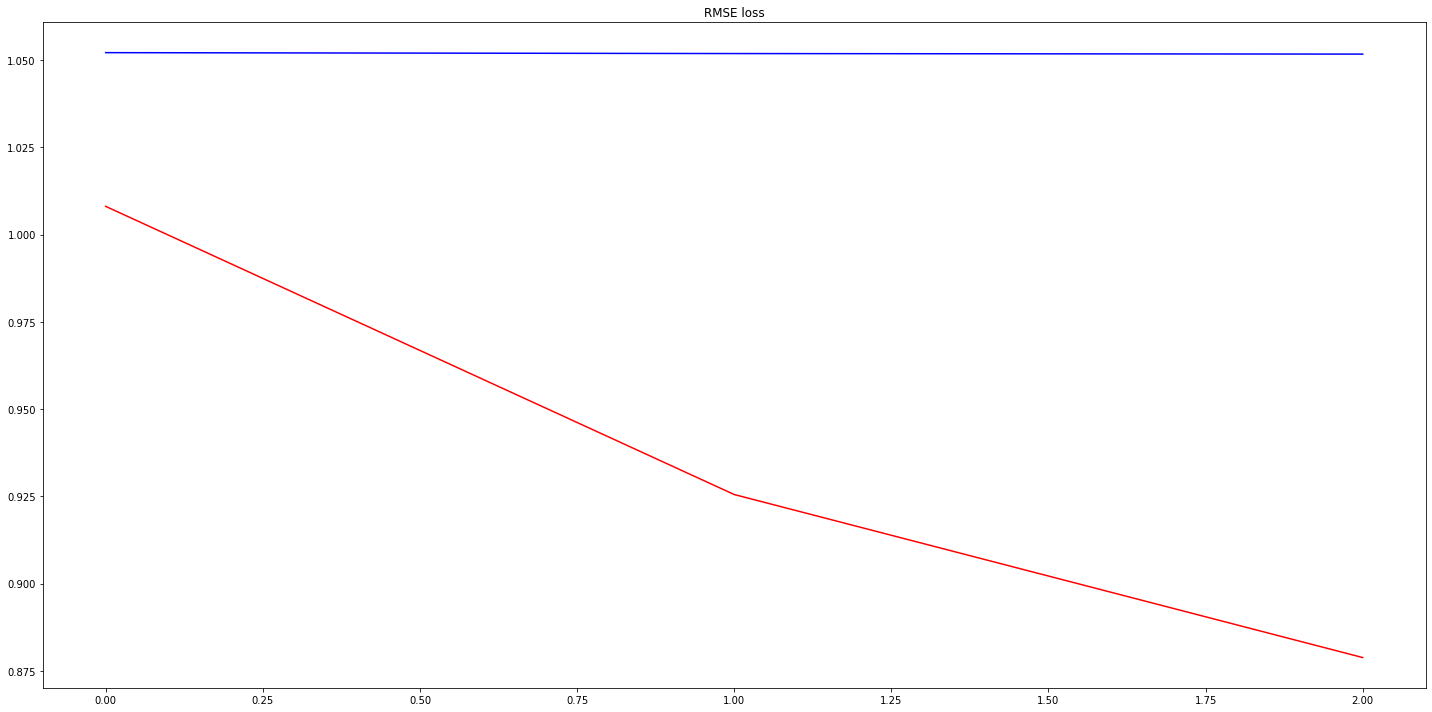

In [ ]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[0.41693538 0.55678904 0.36254621 ... 0.83421063 1.64756417 0.45099825]
 [0.98906696 0.89523447 0.9

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


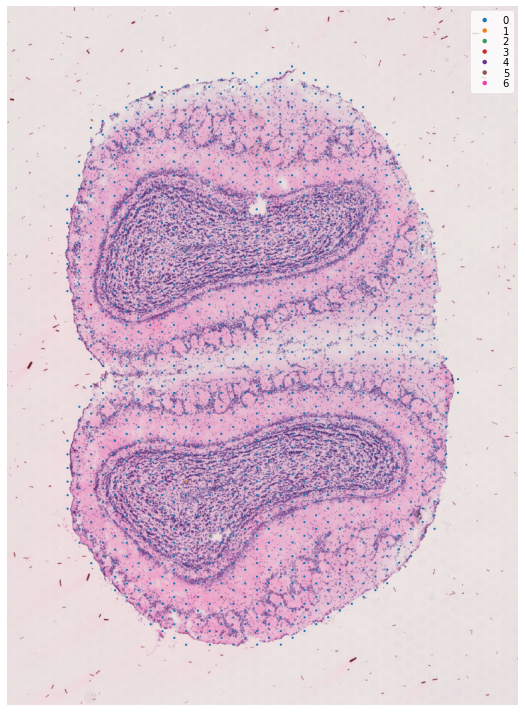

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

## NMF- Random spots + smoothing (full mean between spot and neighbors)

In [7]:
dataset, data = load_visium_data(dataset_name, min_cells=177, min_counts=10, smooth_type='mean')

/content/drive/MyDrive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_expression[f'expr_{row_ind}_{col_ind}'] = top_left_spot_data_expressions['expression'].values.astype(float)
/content/drive/MyDrive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_expression_with_neighbors['expression_mean'] = spot_expression_with_neighbors[expression_column_names].mean(axis=1

In [8]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

In [9]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(data.n_vars, data.n_obs, params)

In [10]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [11]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 71449/71449 [06:56<00:00, 171.37it/s]


Epoch #0 Train Loss: 0.9160607338215839
Epoch #0 Test Loss: 0.9162955476387838


Train epoch 1/300: 100%|██████████| 71449/71449 [07:05<00:00, 168.08it/s]


Epoch #1 Train Loss: 0.906383974837664
Epoch #1 Test Loss: 0.8758871256287438


Train epoch 2/300: 100%|██████████| 71449/71449 [07:07<00:00, 167.23it/s]


Epoch #2 Train Loss: 0.8119184256021543
Epoch #2 Test Loss: 0.7644694460911662


Train epoch 3/300: 100%|██████████| 71449/71449 [07:20<00:00, 162.32it/s]


Epoch #3 Train Loss: 0.7406079021652426
Epoch #3 Test Loss: 0.7015547874985292


Train epoch 4/300: 100%|██████████| 71449/71449 [07:30<00:00, 158.55it/s]


Epoch #4 Train Loss: 0.6934501062627789
Epoch #4 Test Loss: 0.6594895715404883


Train epoch 5/300: 100%|██████████| 71449/71449 [07:41<00:00, 154.98it/s]


Epoch #5 Train Loss: 0.658395471232876
Epoch #5 Test Loss: 0.6279043519281631


Train epoch 6/300: 100%|██████████| 71449/71449 [07:39<00:00, 155.57it/s]


Epoch #6 Train Loss: 0.6310652589562796
Epoch #6 Test Loss: 0.6038173772863857


Train epoch 7/300: 100%|██████████| 71449/71449 [07:49<00:00, 152.19it/s]


Epoch #7 Train Loss: 0.6094964119256397
Epoch #7 Test Loss: 0.5849022218607254


Train epoch 8/300: 100%|██████████| 71449/71449 [07:58<00:00, 149.21it/s]


Epoch #8 Train Loss: 0.5919770222812865
Epoch #8 Test Loss: 0.5695358225809608


Train epoch 9/300: 100%|██████████| 71449/71449 [08:04<00:00, 147.41it/s]


Epoch #9 Train Loss: 0.5773779686197468
Epoch #9 Test Loss: 0.556748361954025


Train epoch 10/300: 100%|██████████| 71449/71449 [08:08<00:00, 146.25it/s]


Epoch #10 Train Loss: 0.565013259912769
Epoch #10 Test Loss: 0.5459639042343789


Train epoch 11/300: 100%|██████████| 71449/71449 [08:16<00:00, 143.81it/s]


Epoch #11 Train Loss: 0.5544247990696948
Epoch #11 Test Loss: 0.5367540560712798


Train epoch 12/300: 100%|██████████| 71449/71449 [08:21<00:00, 142.59it/s]


Epoch #12 Train Loss: 0.5452547436293248
Epoch #12 Test Loss: 0.5287952944942295
Early stopping


### Plot train and test vs epochs

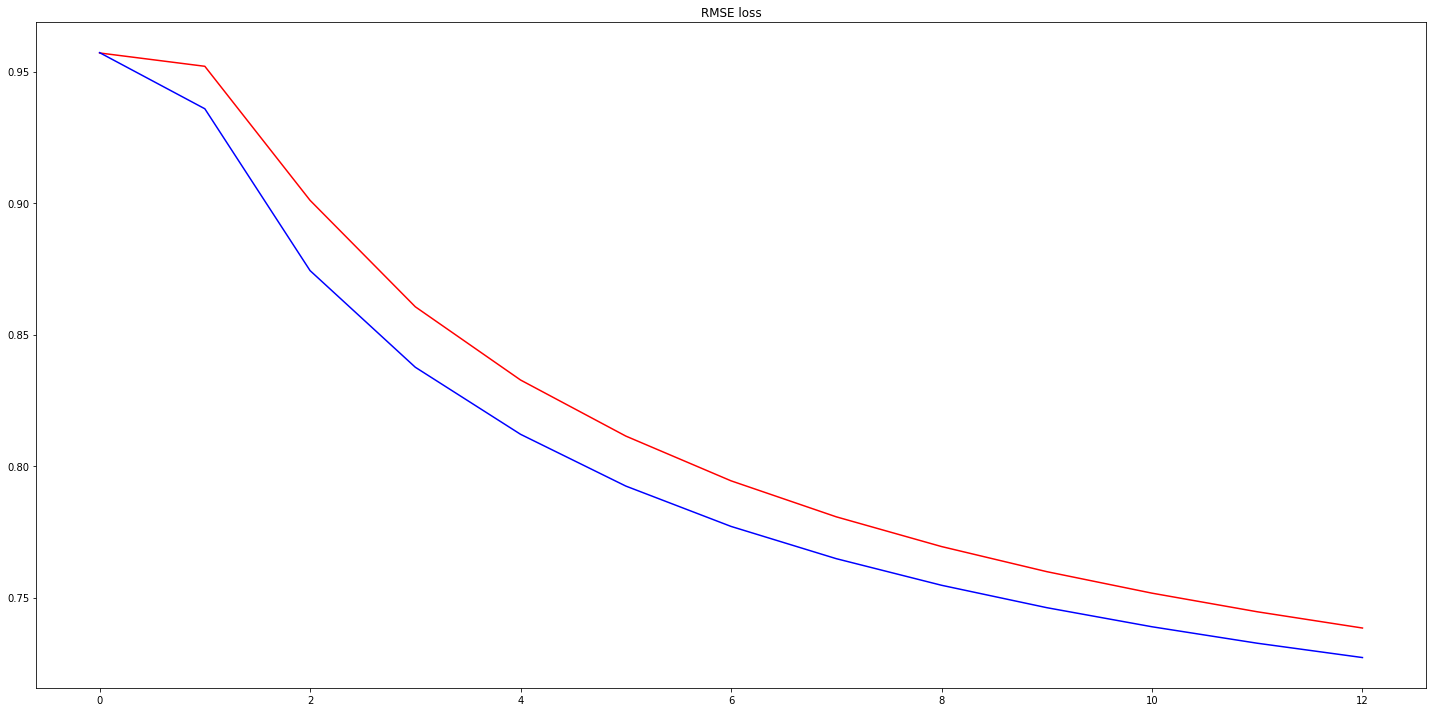

In [12]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [13]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[0.1102446  0.103677   0.03192035 ... 0.47374141 1.13628674 0.03644004]
 [0.49730942 0.29783455 0.3

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


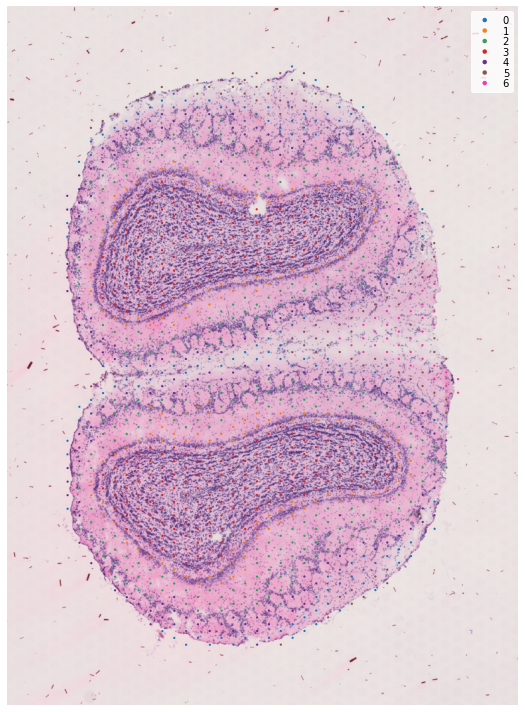

In [14]:
engine.cluster_reconstructed_data(reconstructed_data)

## NMF- Random spots + smoothing (weighted mean between spot (0.5) and neighbors (0.5))

In [7]:
dataset, data = load_visium_data(dataset_name, min_cells=177, min_counts=10, smooth_type='mean_wrt_distance')

/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_expression[f'expr_{row_ind}_{col_ind}'] = top_left_spot_data_expressions['expression'].values.astype(float)
/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_expression_with_neighbors['neighbors_mean'] = spot_expression_with_neighbors[neighbors_names].mean(axis=1)
/cont

In [8]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

In [9]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(data.n_vars, data.n_obs, params)

In [10]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [11]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 71449/71449 [04:52<00:00, 244.43it/s]


Epoch #0 Train Loss: 0.9274032470843155
Epoch #0 Test Loss: 0.926902410626804


Train epoch 1/300: 100%|██████████| 71449/71449 [05:06<00:00, 233.07it/s]


Epoch #1 Train Loss: 0.9116743162577521
Epoch #1 Test Loss: 0.862747447925587


Train epoch 2/300: 100%|██████████| 71449/71449 [05:13<00:00, 227.59it/s]


Epoch #2 Train Loss: 0.8155743498796744
Epoch #2 Test Loss: 0.7661735811384238


Train epoch 3/300: 100%|██████████| 71449/71449 [05:19<00:00, 223.78it/s]


Epoch #3 Train Loss: 0.752691533533437
Epoch #3 Test Loss: 0.7126634785424921


Train epoch 4/300: 100%|██████████| 71449/71449 [05:30<00:00, 215.91it/s]


Epoch #4 Train Loss: 0.7118947012680555
Epoch #4 Test Loss: 0.6779429947106189


Train epoch 5/300: 100%|██████████| 71449/71449 [05:47<00:00, 205.74it/s]


Epoch #5 Train Loss: 0.6825135996134537
Epoch #5 Test Loss: 0.6525400171978311


Train epoch 6/300: 100%|██████████| 71449/71449 [05:53<00:00, 202.26it/s]


Epoch #6 Train Loss: 0.6595973617379044
Epoch #6 Test Loss: 0.6327640756170817


Train epoch 7/300: 100%|██████████| 71449/71449 [06:05<00:00, 195.41it/s]


Epoch #7 Train Loss: 0.6413367998749495
Epoch #7 Test Loss: 0.6172438008680532


Train epoch 8/300: 100%|██████████| 71449/71449 [06:14<00:00, 191.03it/s]


Epoch #8 Train Loss: 0.6266010158492566
Epoch #8 Test Loss: 0.6047653745129762


Train epoch 9/300: 100%|██████████| 71449/71449 [06:12<00:00, 192.04it/s]


Epoch #9 Train Loss: 0.6144242011609578
Epoch #9 Test Loss: 0.5944554747922977


Train epoch 10/300: 100%|██████████| 71449/71449 [06:30<00:00, 182.96it/s]


Epoch #10 Train Loss: 0.6041424334538386
Epoch #10 Test Loss: 0.585755189326001


Train epoch 11/300: 100%|██████████| 71449/71449 [06:36<00:00, 180.38it/s]


Epoch #11 Train Loss: 0.5953260664733601
Epoch #11 Test Loss: 0.5783172620084408
Early stopping


### Plot train and test vs epochs

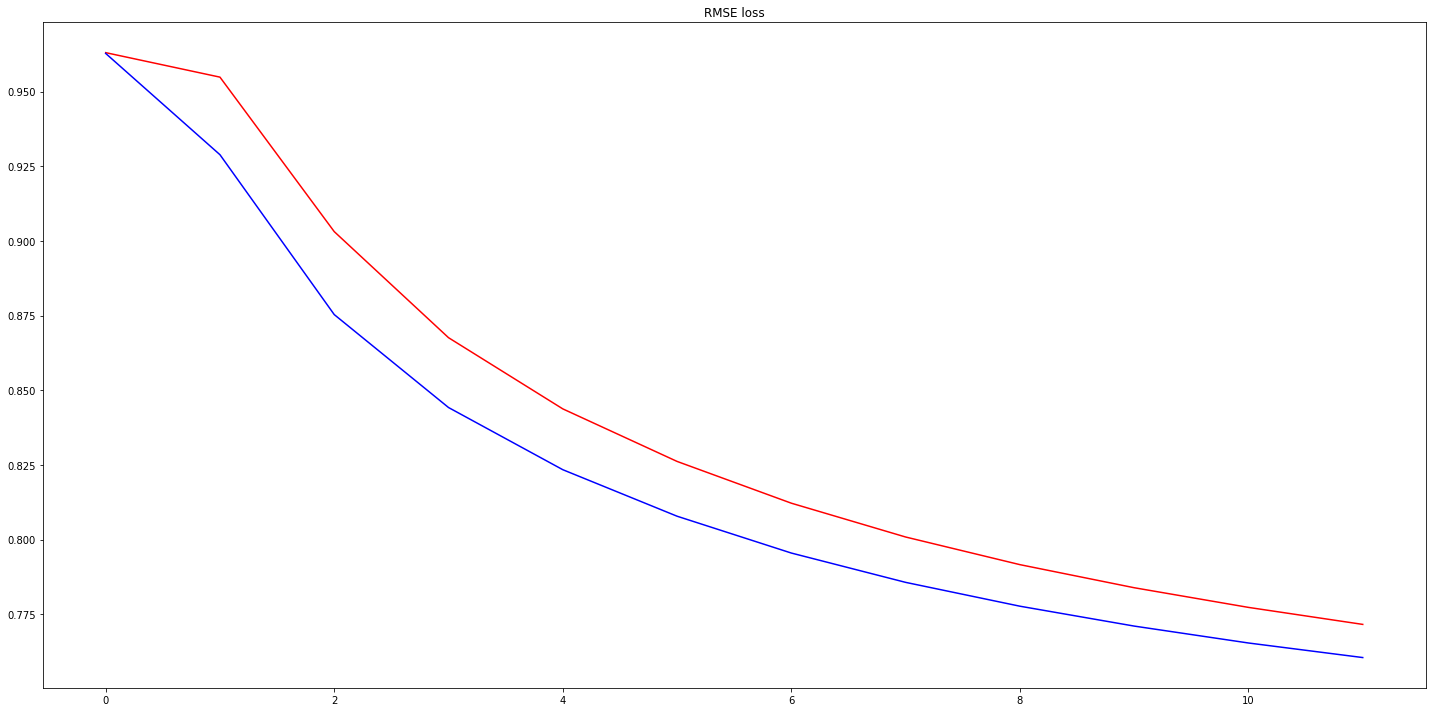

In [12]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [13]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[6.32384419e-02 2.91867778e-02 2.22154893e-03 ... 4.33755845e-01
  1.06910717e+00 2.52712816e-02]
 

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


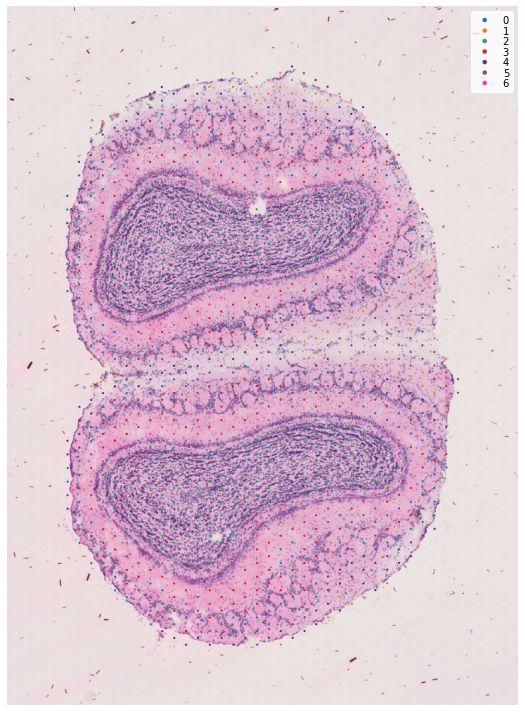

In [14]:
engine.cluster_reconstructed_data(reconstructed_data)

## NMF- Random spots + smoothing of 2 spots away 

In [15]:
dataset, data = load_visium_data(dataset_name, min_cells=177, min_counts=10, smooth_type='mean_wrt_distance_x2')

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_expression[f'expr_{row_ind}_{col_ind}'] = top_left_spot_data_expressions['expression'].values.astype(float)
/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [16]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

[autoreload of train failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code/train.py", line 23, in <module>
    from models import NMF, EdgeDetectNN, NeighborsDetectNN
ImportError: cannot import name 'NeighborsDetectNN' from 'models' (/

In [17]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(data.n_vars, data.n_obs, params)

In [18]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [19]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 71449/71449 [05:22<00:00, 221.80it/s]


Epoch #0 Train Loss: 0.8894546941075386
Epoch #0 Test Loss: 0.8883741133878253


Train epoch 1/300: 100%|██████████| 71449/71449 [05:32<00:00, 214.86it/s]


Epoch #1 Train Loss: 0.8804673965641798
Epoch #1 Test Loss: 0.8515391424334378


Train epoch 2/300: 100%|██████████| 71449/71449 [05:31<00:00, 215.81it/s]


Epoch #2 Train Loss: 0.7840874815903471
Epoch #2 Test Loss: 0.7329219852289937


Train epoch 3/300: 100%|██████████| 71449/71449 [05:48<00:00, 204.82it/s]


Epoch #3 Train Loss: 0.7076034378443392
Epoch #3 Test Loss: 0.6648963863310223


Train epoch 4/300: 100%|██████████| 71449/71449 [06:00<00:00, 198.12it/s]


Epoch #4 Train Loss: 0.6561848459319675
Epoch #4 Test Loss: 0.6181301722891235


Train epoch 5/300: 100%|██████████| 71449/71449 [06:06<00:00, 195.21it/s]


Epoch #5 Train Loss: 0.616840233405972
Epoch #5 Test Loss: 0.5822380449070603


Train epoch 6/300: 100%|██████████| 71449/71449 [06:14<00:00, 190.72it/s]


Epoch #6 Train Loss: 0.586052910973364
Epoch #6 Test Loss: 0.5548175594324224


Train epoch 7/300: 100%|██████████| 71449/71449 [06:20<00:00, 187.97it/s]


Epoch #7 Train Loss: 0.5616048580824977
Epoch #7 Test Loss: 0.5330418539110049


Train epoch 8/300: 100%|██████████| 71449/71449 [06:21<00:00, 187.18it/s]


Epoch #8 Train Loss: 0.5415448659759372
Epoch #8 Test Loss: 0.5151696488722406


Train epoch 9/300: 100%|██████████| 71449/71449 [06:38<00:00, 179.26it/s]


Epoch #9 Train Loss: 0.5247177268396414
Epoch #9 Test Loss: 0.5002327218191516


Train epoch 10/300: 100%|██████████| 71449/71449 [06:39<00:00, 178.86it/s]


Epoch #10 Train Loss: 0.5104258345883361
Epoch #10 Test Loss: 0.48759547173568907


Train epoch 11/300: 100%|██████████| 71449/71449 [06:45<00:00, 176.19it/s]


Epoch #11 Train Loss: 0.4981451035858318
Epoch #11 Test Loss: 0.4767561325372966


Train epoch 12/300: 100%|██████████| 71449/71449 [06:50<00:00, 173.88it/s]


Epoch #12 Train Loss: 0.4874654694280578
Epoch #12 Test Loss: 0.46734075622882987


Train epoch 13/300: 100%|██████████| 71449/71449 [07:08<00:00, 166.86it/s]


Epoch #13 Train Loss: 0.478075856490979
Epoch #13 Test Loss: 0.4590723439610831
Early stopping


### Plot train and test vs epochs

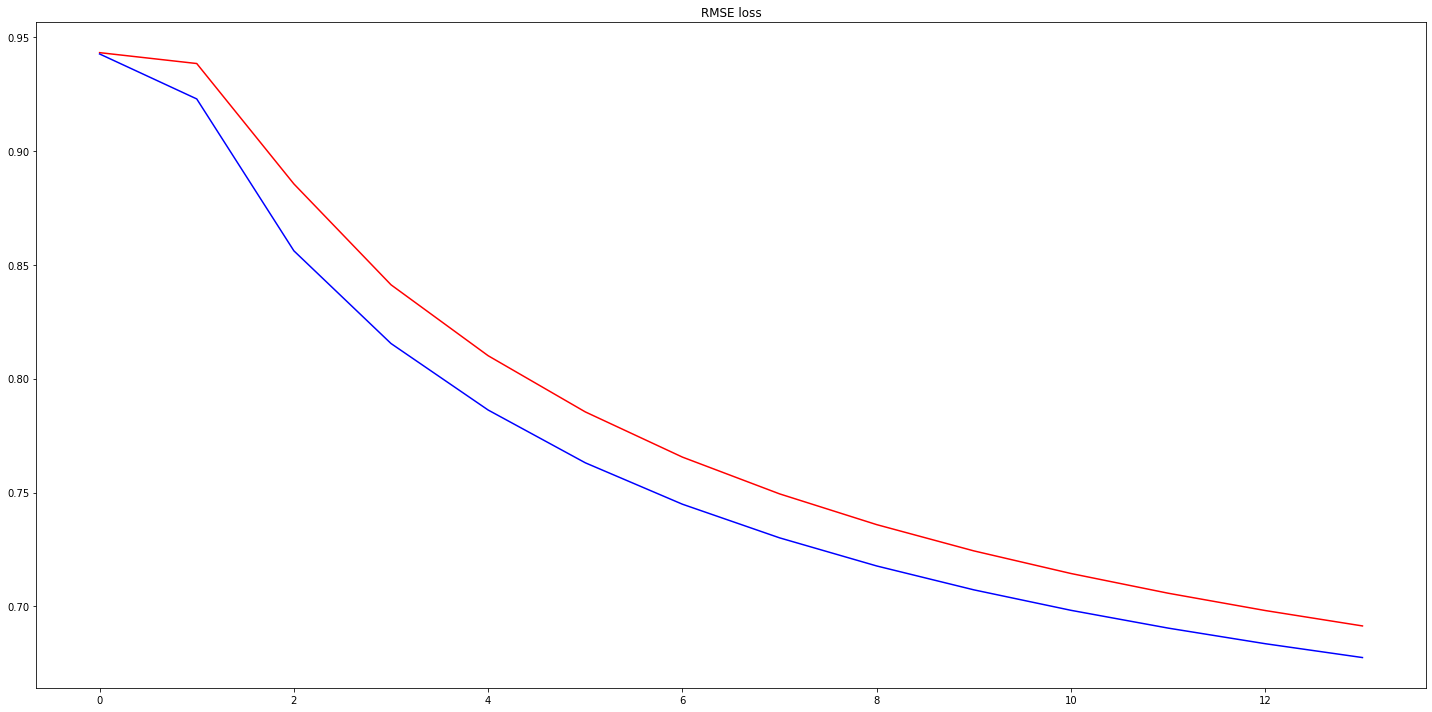

In [20]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [21]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[0.05969568 0.04575887 0.04252177 ... 0.55392933 1.32745707 0.01326495]
 [0.43044117 0.27619222 0.2

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


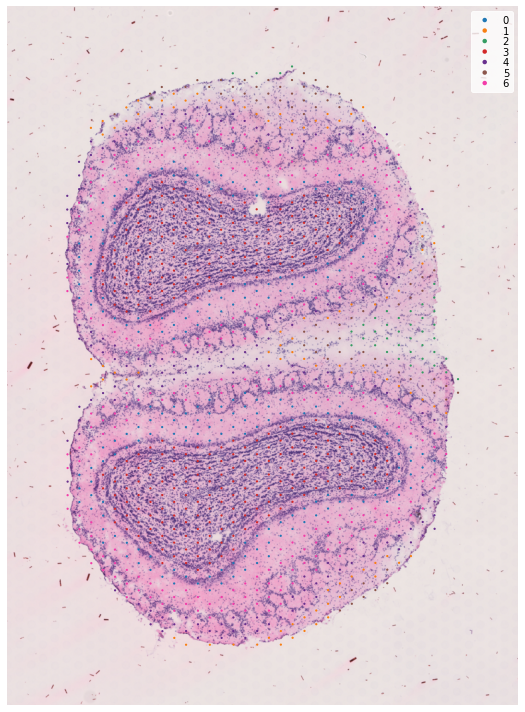

In [22]:
engine.cluster_reconstructed_data(reconstructed_data)

## NMF- Random spots + smoothing of 2 spots away + only same side of edge

In [8]:
dataset, data = load_visium_data(dataset_name, min_cells=177, min_counts=10, smooth_type='mean_wrt_edge')

/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spot_expression[f'{neighbor_name[0]}_{row_ind}_{col_ind}'] = top_left_spot_data_expressions['expression'].values.astype(float)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/content/drive/My Drive/Studies 2/Year 2/Final Project/project_git_repo/code/load_data.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [9]:
params = {
    'learning_rate': 0.1,
    'optimizer': "SGD",
    'latent_dim': 40,
    'batch_size': 128
}

In [10]:
number_of_spots = data.n_obs
number_of_genes = data.n_vars
nmf_model = NMF(data.n_vars, data.n_obs, params)

In [11]:
nmf_execute = engine(model = nmf_model,
                    model_name = 'NMF',
                    params = params,
                    epochs = 300,
                    criterion = RMSELossWithoutZeros(),
                    dl_train = dataset.dl_train,
                    dl_test = dataset.dl_valid,
                    device = device)

NMF(
  (embedding_genes): Embedding(9529, 40)
  (embedding_spots): Embedding(1186, 40)
)


In [12]:
nmf_train_losses, nmf_test_losses = nmf_execute.execute()

Train epoch 0/300: 100%|██████████| 71449/71449 [06:38<00:00, 179.12it/s]


Epoch #0 Train Loss: 0.9457478009073298
Epoch #0 Test Loss: 0.9427055118176333


Train epoch 1/300: 100%|██████████| 71449/71449 [06:48<00:00, 174.79it/s]


Epoch #1 Train Loss: 0.9240920137576405
Epoch #1 Test Loss: 0.8501590027818656


Train epoch 2/300: 100%|██████████| 71449/71449 [06:56<00:00, 171.42it/s]


Epoch #2 Train Loss: 0.8161586325342474
Epoch #2 Test Loss: 0.752534665686346


Train epoch 3/300: 100%|██████████| 71449/71449 [07:05<00:00, 168.03it/s]


Epoch #3 Train Loss: 0.7500824983916164
Epoch #3 Test Loss: 0.6981682828737271


Train epoch 4/300: 100%|██████████| 71449/71449 [07:09<00:00, 166.53it/s]


Epoch #4 Train Loss: 0.7068634567931602
Epoch #4 Test Loss: 0.6624733376728841


Train epoch 5/300: 100%|██████████| 71449/71449 [07:24<00:00, 160.89it/s]


Epoch #5 Train Loss: 0.6753442526718265
Epoch #5 Test Loss: 0.6361155830513949


Train epoch 6/300: 100%|██████████| 71449/71449 [07:30<00:00, 158.62it/s]


Epoch #6 Train Loss: 0.6509217734550429
Epoch #6 Test Loss: 0.6159957224380807


Train epoch 7/300: 100%|██████████| 71449/71449 [07:37<00:00, 156.23it/s]


Epoch #7 Train Loss: 0.6316645985280812
Epoch #7 Test Loss: 0.6002628351120958


Train epoch 8/300: 100%|██████████| 71449/71449 [07:32<00:00, 157.93it/s]


Epoch #8 Train Loss: 0.6160857399690441
Epoch #8 Test Loss: 0.5875393587151508


Train epoch 9/300: 100%|██████████| 71449/71449 [07:35<00:00, 156.87it/s]


Epoch #9 Train Loss: 0.6031164101657315
Epoch #9 Test Loss: 0.5769214341306921


Train epoch 10/300: 100%|██████████| 71449/71449 [07:41<00:00, 154.96it/s]


Epoch #10 Train Loss: 0.5920609883150129
Epoch #10 Test Loss: 0.5678561686434593


Train epoch 11/300: 100%|██████████| 71449/71449 [07:49<00:00, 152.21it/s]


Epoch #11 Train Loss: 0.5824886481810486
Epoch #11 Test Loss: 0.5600208565207159
Early stopping


### Plot train and test vs epochs

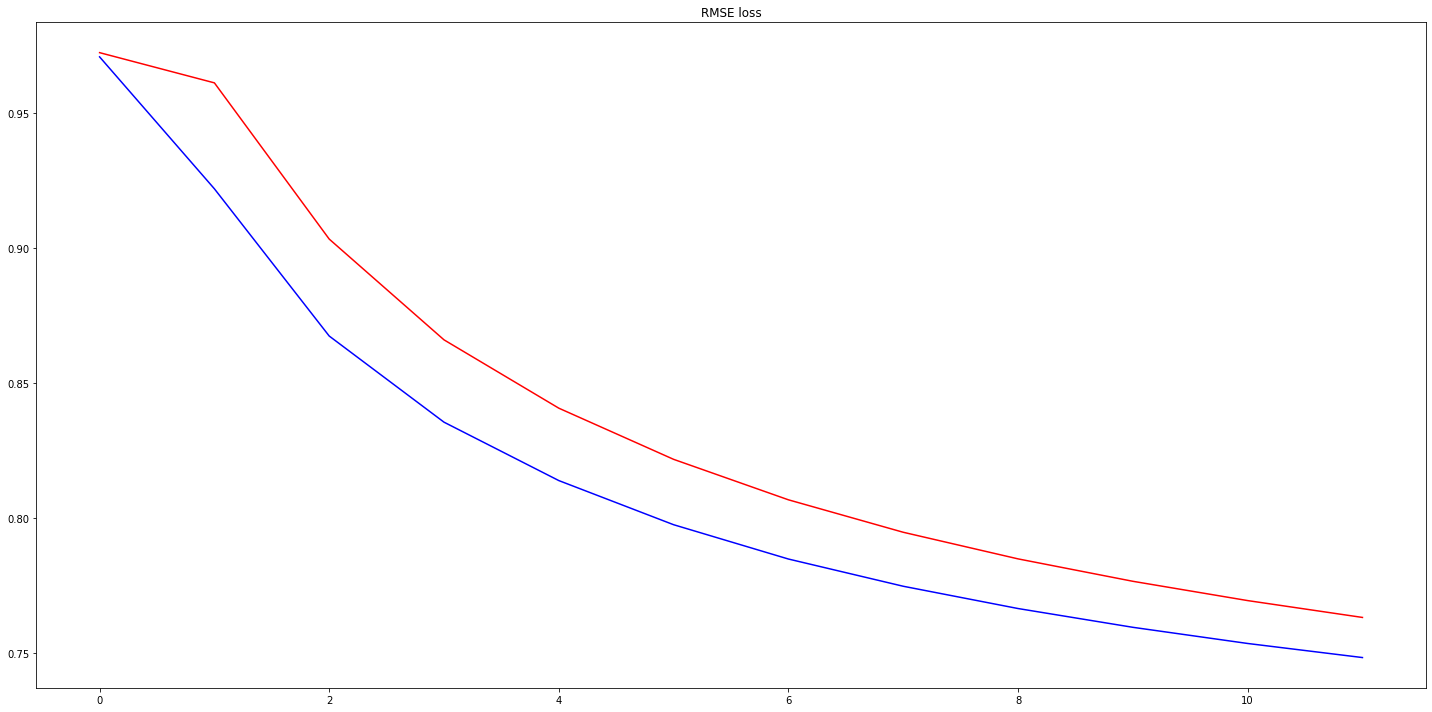

In [13]:
plot_train_vs_test(nmf_train_losses, nmf_test_losses, "RMSE loss")

### Reconstruct data

In [14]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nmf_model, dataset, data, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  (0, 3964)	1.0
  (0, 1760)	2.0
  (0, 8731)	1.0
  (0, 2402)	1.0
  (0, 6825)	1.0
  (0, 3744)	1.0
  (0, 3746)	1.0
  (0, 5969)	1.0
  (0, 6350)	1.0
  (0, 1531)	1.0
  (0, 7469)	1.0
  (0, 4043)	1.0
  (0, 7871)	1.0
  (0, 4654)	1.0
  (0, 5184)	1.0
  (0, 3325)	1.0
  (0, 1186)	1.0
  (0, 3164)	1.0
  (0, 3072)	1.0
  (0, 6163)	1.0
  (0, 5250)	1.0
  (0, 4762)	1.0
  (0, 4660)	1.0
  (0, 5647)	1.0
  (0, 5746)	2.0
  :	:
  (1184, 4463)	3.0
  (1184, 7282)	1.0
  (1184, 5687)	11.0
  (1184, 1418)	1.0
  (1184, 6630)	1.0
  (1184, 6555)	2.0
  (1184, 3306)	6.0
  (1184, 6458)	1.0
  (1184, 8425)	24.0
  (1184, 6224)	3.0
  (1184, 3484)	1.0
  (1184, 9521)	196.0
  (1184, 9522)	125.0
  (1184, 9517)	891.0
  (1184, 9518)	499.0
  (1184, 9516)	3.0
  (1184, 9515)	524.0
  (1184, 9519)	682.0
  (1184, 9523)	42.0
  (1184, 9525)	6.0
  (1184, 9524)	260.0
  (1184, 9526)	36.0
  (1184, 9520)	295.0
  (1184, 8952)	1.0
  (1184, 138)	2.0 [[0.14189494 0.10944458 0.0839462  ... 0.53743118 1.13366914 0.06786057]
 [0.37890261 0.29457065 0.3

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Cluster and plot reconstructed data

Normalization step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']
Applying Kmeans clustering ...
Kmeans clustering is done! The labels are stored in adata.obs["kmeans"]


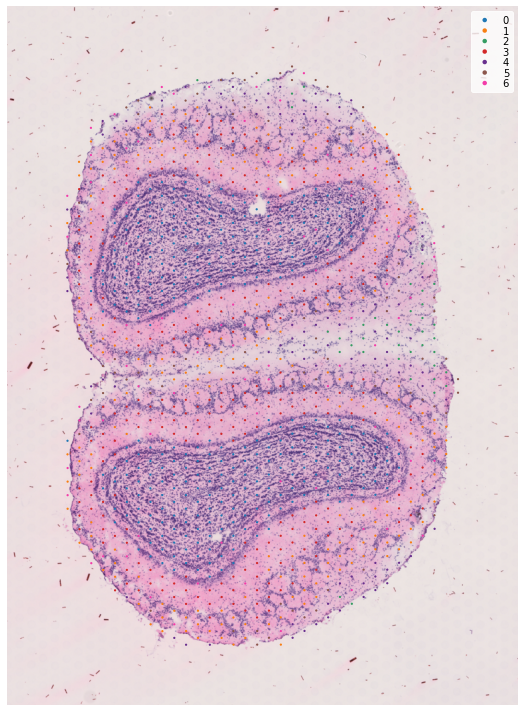

In [15]:
engine.cluster_reconstructed_data(reconstructed_data)

## Train edge detection classifier

In [ ]:
from load_data import load_edge_detection_data
load_edge_detection_data(dataset_name)

(<torch.utils.data.dataloader.DataLoader at 0x7f35810fff70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f35810ff700>)

# NN- MF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NNMF
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 Linear Layer

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "RMSprop",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [(20,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 10,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

NNMF(
  (embedding_genes): Embedding(32286, 20)
  (embedding_spots): Embedding(1186, 20)
  (linear_layers): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

Train epoch 0/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.39it/s]


Epoch #0 Train Loss: 1.715077950765421
Epoch #0 Test Loss: 1.1432739220273862


Train epoch 1/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.48it/s]


Epoch #1 Train Loss: 1.4558057859680813
Epoch #1 Test Loss: 1.1426385038114741


Train epoch 2/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 58.66it/s]


Epoch #2 Train Loss: 1.3583749468207718
Epoch #2 Test Loss: 1.1421958867106463


Train epoch 3/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.22it/s]


Epoch #3 Train Loss: 1.3069062600394739
Epoch #3 Test Loss: 1.1418163653589695


Train epoch 4/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.97it/s]


Epoch #4 Train Loss: 1.2750337305282085
Epoch #4 Test Loss: 1.1420464775417325


Train epoch 5/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.69it/s]


Epoch #5 Train Loss: 1.2533327516711268
Epoch #5 Test Loss: 1.1421073479159147


Train epoch 6/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.12it/s]


Epoch #6 Train Loss: 1.2375957593478204
Epoch #6 Test Loss: 1.1420722943277333


Train epoch 7/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 59.55it/s]


Epoch #7 Train Loss: 1.2256633870287823
Epoch #7 Test Loss: 1.1419659700887672


Train epoch 8/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.43it/s]


Epoch #8 Train Loss: 1.2162969217632982
Epoch #8 Test Loss: 1.1419787936257435


Train epoch 9/10: 100%|██████████████████████████████████████████████████████████████| 750/750 [00:12<00:00, 60.14it/s]


Epoch #9 Train Loss: 1.2087504861272487
Epoch #9 Test Loss: 1.1419060227512068


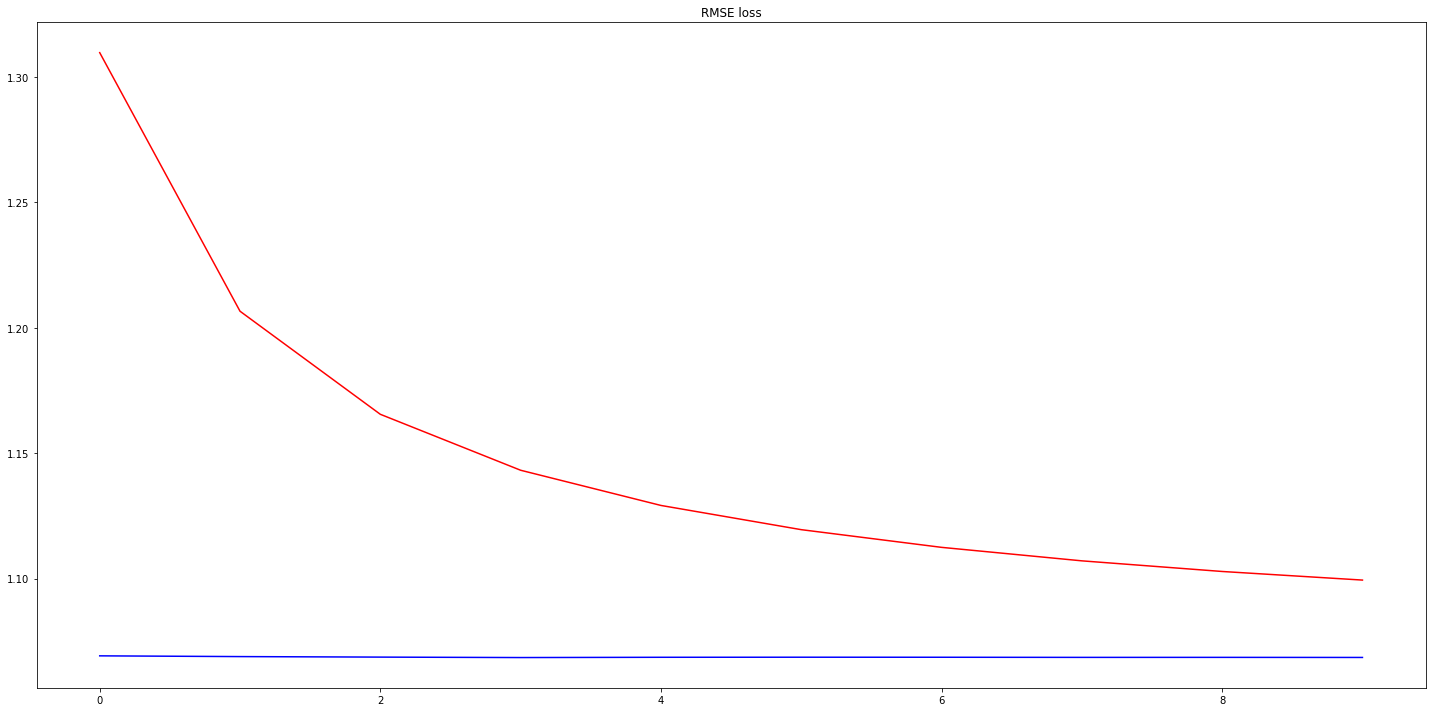

In [ ]:
plot_train_vs_test(nnmf_train_losses, nnmf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nnmf_model, dataset, data, DEVICE)

  (0, 18)	5.0
  (0, 26)	2.0
  (0, 73)	2.0
  (0, 78)	3.0
  (0, 55)	2.0
  (0, 72)	1.0
  (0, 80)	3.0
  (0, 40)	2.0
  (0, 62)	1.0
  (0, 84)	1.0
  (0, 0)	1.0
  (0, 47)	1.0
  (0, 35)	2.0
  (0, 54)	2.0
  (0, 25)	3.0
  (0, 31)	2.0
  (0, 81)	2.0
  (0, 52)	1.0
  (0, 3)	2.0
  (0, 71)	1.0
  (0, 70)	2.0
  (0, 65)	1.0
  (0, 24)	1.0
  (0, 27)	7.0
  (0, 51)	2.0
  :	:
  (1184, 56)	23.0
  (1184, 49)	9.0
  (1184, 36)	15.0
  (1184, 7)	24.0
  (1184, 64)	18.0
  (1184, 9)	17.0
  (1184, 68)	20.0
  (1184, 44)	13.0
  (1184, 5)	13.0
  (1184, 10)	25.0
  (1184, 22)	24.0
  (1184, 16)	32.0
  (1184, 23)	34.0
  (1184, 37)	19.0
  (1184, 85)	24.0
  (1184, 95)	196.0
  (1184, 96)	125.0
  (1184, 91)	891.0
  (1184, 92)	499.0
  (1184, 90)	524.0
  (1184, 93)	682.0
  (1184, 97)	42.0
  (1184, 98)	260.0
  (1184, 99)	36.0
  (1184, 94)	295.0 [[list([3.1679160594940186]) list([3.1769323348999023])
  list([3.1682467460632324]) ... list([3.1713924407958984])
  list([3.18613600730896]) list([3.172372341156006])]
 [list([3.199940681457

ValueError: setting an array element with a sequence.

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

## 3 Linear Layers

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "Adam",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [(40,100), (100,50), (50,10)]
}

In [ ]:
nnmf_model = NNMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_nnmf = engine(model = nnmf_model,
                    model_name = 'NNMF',
                    params = params,
                    epochs = 10,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

In [ ]:
nnmf_train_losses, nnmf_test_losses = train_nnmf.execute()

In [ ]:
plot_train_vs_test(nnmf_train_losses, nnmf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(nnmf_model, dataset, data, DEVICE)

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)

# NeuMF

In [ ]:
%load_ext autoreload
%autoreload 2
from models import NeuMF

In [ ]:
params = {
    'learning_rate': 0.001,
    'optimizer': "SGD",
    'latent_dim': 20,
    'batch_size': BATCH_SIZE,
    'layers_sizes': [40, 10]
}

In [ ]:
neumf_model = NeuMF(number_of_genes, number_of_spots, params, DEVICE)

In [ ]:
train_neumf = engine(model = neumf_model,
                    model_name = 'NeuMF',
                    params = params,
                    epochs = 5,
                    dl_train = dataset.dl_train_top_genes,
                    dl_test = dataset.dl_test_top_genes,
                    device = DEVICE)

In [ ]:
neumf_train_losses, neumf_test_losses = train_neumf.execute()

In [ ]:
plot_train_vs_test(neumf_train_losses, neumf_test_losses, "RMSE loss")

In [ ]:
df_expressions_preds, df_expressions_true, reconstructed_data = engine.create_reconstructed_data(neumf_model, dataset, data, DEVICE)

In [ ]:
plot_true_vs_reconstructed_histogram(df_expressions_true, df_expressions_preds)

In [ ]:
engine.cluster_reconstructed_data(reconstructed_data)